In [ ]:
#!unzip "/content/drive/MyDrive/Plante disease/PlantVillage.zip" -d "/content/drive/MyDrive/Plante disease"

## Import libraries we're gonna need

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 25
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/Plante disease'
width=256
height=256
depth=3

## Convert images into arrays

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

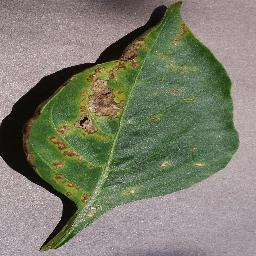

In [4]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/Plante disease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")

## Read images and load them into listes

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)
print(image_size)

1657


In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [10]:
np_image_list[0]

array([[[0.3804, 0.3687, 0.4275],
        [0.357 , 0.3452, 0.4038],
        [0.4785, 0.4666, 0.5254],
        ...,
        [0.5845, 0.5806, 0.643 ],
        [0.604 , 0.6   , 0.6626],
        [0.643 , 0.639 , 0.702 ]],

       [[0.4941, 0.4824, 0.541 ],
        [0.396 , 0.3843, 0.443 ],
        [0.4626, 0.451 , 0.51  ],
        ...,
        [0.5845, 0.5806, 0.643 ],
        [0.5806, 0.5767, 0.639 ],
        [0.5923, 0.5884, 0.651 ]],

       [[0.5293, 0.5176, 0.5767],
        [0.341 , 0.3293, 0.3882],
        [0.5566, 0.545 , 0.604 ],
        ...,
        [0.6   , 0.596 , 0.6587],
        [0.5767, 0.5728, 0.6353],
        [0.569 , 0.565 , 0.6274]],

       ...,

       [[0.5845, 0.5566, 0.608 ],
        [0.647 , 0.6196, 0.6704],
        [0.8276, 0.8   , 0.851 ],
        ...,
        [0.596 , 0.5605, 0.612 ],
        [0.596 , 0.5605, 0.612 ],
        [0.5923, 0.5566, 0.608 ]],

       [[0.612 , 0.5845, 0.6353],
        [0.5293, 0.502 , 0.5527],
        [0.5605, 0.533 , 0.5845],
        .

## Split data into train and test

In [11]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

## Create our model

In [13]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


## Let's train our model

In [16]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
53/53 [==============================] - 55s 450ms/step - loss: 0.8251 - accuracy: 0.2767 - val_loss: 0.5944 - val_accuracy: 0.1596
Epoch 2/25
53/53 [==============================] - 22s 414ms/step - loss: 0.4611 - accuracy: 0.4300 - val_loss: 1.2728 - val_accuracy: 0.1506
Epoch 3/25
53/53 [==============================] - 22s 414ms/step - loss: 0.4282 - accuracy: 0.3630 - val_loss: 1.2807 - val_accuracy: 0.0873
Epoch 4/25
53/53 [==============================] - 22s 414ms/step - loss: 0.3019 - accuracy: 0.5159 - val_loss: 0.8199 - val_accuracy: 0.1596
Epoch 5/25
53/53 [==============================] - 22s 419ms/step - loss: 0.2266 - accuracy: 0.6746 - val_loss: 0.8465 - val_accuracy: 0.1295
Epoch 6/25
53/53 [==============================] - 22s 415ms/step - loss: 0.2030 - accuracy: 0.6661 - val_loss: 0.7228 - val_accuracy: 0.1627
Epoch 7/25
53/53 [==============================] - 22s 408ms/step - loss: 0.1772 - accuracy: 0.7155 - val_loss: 0.7911 - val_accuracy: 0.1596

## Evaluate our model

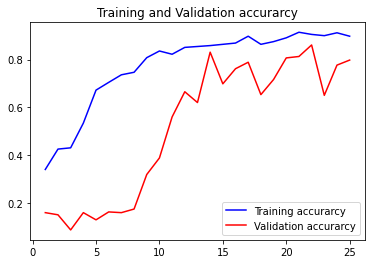

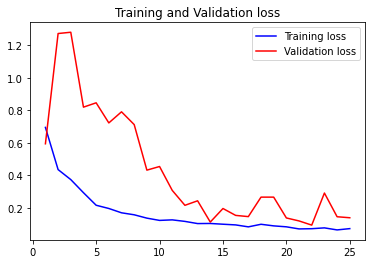

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
11/11 [==============================] - 1s 65ms/step - loss: 0.1393 - accuracy: 0.7982
Test Accuracy: 79.81927990913391


## Saving the model

In [19]:
model.save('/content/drive/MyDrive/Plante_disease_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Plante_disease_model/assets


In [21]:
from keras.models import load_model
saved_model = load_model('/content/drive/MyDrive/Plante_disease_model')

## Making predictions

In [35]:
#image_dir="path\\plantdisease_dataset\\PlantVillage\\Potato___Early_blight"

image_dir="/content/drive/MyDrive/Plante disease/PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG"


im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

#### With our first model

In [36]:
result=model.predict(npp_image)

print(result)

[[8.2472332e-07 2.3888342e-06 9.9989879e-01 2.3542119e-09 2.6274483e-05
  1.6013044e-09 4.3793449e-09 7.1752838e-05 1.0651358e-08]]


In [37]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.9998988
Potato___Early_blight


#### With the saved model

In [38]:
result=saved_model.predict(npp_image)

print(result)

[[8.2472332e-07 2.3888342e-06 9.9989879e-01 2.3542119e-09 2.6274483e-05
  1.6013044e-09 4.3793449e-09 7.1752838e-05 1.0651358e-08]]


In [39]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.9998988
Potato___Early_blight
